In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [2]:
import os
import random
import shutil
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras_tuner import Hyperband

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -q /content/drive/MyDrive/transaction-yes-no.zip -d /content/

transaction-yes-no/Yes/❾❻⓿❼⓿❶❽❽❶❺  Wonder Loan Customer care helpline number_9607018815 - Copy.jpg:  mismatching "local" filename (transaction-yes-no/Yes/тЭ╛тЭ╗тУ┐тЭ╝тУ┐тЭ╢тЭ╜тЭ╜тЭ╢тЭ║  Wonder Loan Customer care helpline number_9607018815 - Copy.jpg),
         continuing with "central" filename version
transaction-yes-no/Yes/❾❻⓿❼⓿❶❽❽❶❺  Wonder Loan Customer care helpline number_9607018815.jpg:  mismatching "local" filename (transaction-yes-no/Yes/тЭ╛тЭ╗тУ┐тЭ╝тУ┐тЭ╢тЭ╜тЭ╜тЭ╢тЭ║  Wonder Loan Customer care helpline number_9607018815.jpg),
         continuing with "central" filename version


In [6]:
# Paths
DATASET_DIR = "/content/transaction-yes-no/"
TRAIN_DIR = "/content/transaction-yes-no/train/"
TEST_DIR = "/content/transaction-yes-no/test/"

In [7]:
MODEL_SAVE_DIR = "/content/saved_models"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

In [8]:
# Ensure directory structure exists
for split_dir in [TRAIN_DIR, TEST_DIR]:
    for class_name in ['Yes', 'No']:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

In [9]:
# Count images
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('jpg', 'jpeg', 'png'))])

In [10]:
# Split data function
def split_data(source_dir, train_dir, test_dir, train_ratio=0.8):
    for class_name in ['Yes', 'No']:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)

        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        test_images = images[split_index:]

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

split_data(DATASET_DIR, TRAIN_DIR, TEST_DIR, train_ratio=0.8)

In [11]:
# Data augmentation function
def augment_class(class_dir, target_count):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    current_count = len(images)

    while current_count < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_dir, save_format='jpeg'):
            current_count += 1
            if current_count >= target_count:
                break

In [12]:
# Undersampling for majority class
def undersample_class(class_dir, target_count):
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    random.shuffle(images)

    for img_name in images[target_count:]:
        img_path = os.path.join(class_dir, img_name)
        os.remove(img_path)

In [13]:
# Balance dataset
train_yes_dir = os.path.join(TRAIN_DIR, 'Yes')
train_no_dir = os.path.join(TRAIN_DIR, 'No')

yes_count = count_images(train_yes_dir)
no_count = count_images(train_no_dir)

print(f"Before balancing: Yes = {yes_count}, No = {no_count}")

Before balancing: Yes = 1121, No = 2837


In [14]:
target_count = max(yes_count, no_count)
augment_class(train_yes_dir, target_count)
undersample_class(train_no_dir, target_count)

yes_count = count_images(train_yes_dir)
no_count = count_images(train_no_dir)

print(f"After balancing: Yes = {yes_count}, No = {no_count}")

After balancing: Yes = 2719, No = 2837


In [15]:
# Data generators
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [16]:

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5556 images belonging to 2 classes.
Found 990 images belonging to 2 classes.


In [17]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [18]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.TPUStrategy(resolver)

In [19]:
# Define model with ResNet50 as backbone
with tf.distribute.get_strategy().scope():
    base_model_resnet = ResNet50(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
    base_model_resnet.trainable = False 

    model_resnet = Sequential([
        base_model_resnet,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

    model_resnet.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,858,305 (91.01 MB)

 Trainable params: 270,593 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
# Define model with MobileNet as backbone
with tf.distribute.get_strategy().scope():
    base_model_mobilenet = MobileNet(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
    base_model_mobilenet.trainable = False  

    model_mobilenet = Sequential([
        base_model_mobilenet,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  
    ])

    model_mobilenet.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

model_mobilenet.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,368,385 (12.85 MB)

 Trainable params: 139,521 (545.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [21]:

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

EPOCHS = 20

In [22]:
#ResNet50 model
history_resnet = model_resnet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

resnet_model_path = os.path.join(MODEL_SAVE_DIR, 'resnet_model.h5')
model_resnet.save(resnet_model_path)
print(f"ResNet50 model saved at {resnet_model_path}")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/174 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.5165 - loss: 1.0338

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


174/174 ━━━━━━━━━━━━━━━━━━━━ 60s 259ms/step - accuracy: 0.5180 - loss: 1.0185 - val_accuracy: 0.6970 - val_loss: 0.8430 - learning_rate: 1.0000e-04
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 63s 189ms/step - accuracy: 0.5754 - loss: 0.8165 - val_accuracy: 0.6949 - val_loss: 0.7383 - learning_rate: 1.0000e-04
Epoch 3/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 32s 181ms/step - accuracy: 0.6566 - loss: 0.7183 - val_accuracy: 0.7172 - val_loss: 0.6917 - learning_rate: 1.0000e-04
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 189ms/step - accuracy: 0.7063 - loss: 0.6444 - val_accuracy: 0.7283 - val_loss: 0.6163 - learning_rate: 1.0000e-04
Epoch 5/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 40s 182ms/step - accuracy: 0.7821 - loss: 0.5752 - val_accuracy: 0.7556 - val_loss: 0.5930 - learning_rate: 1.0000e-04
Epoch 6/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.7956 - loss: 0.5319 - val_accuracy: 0.7677 - val_loss: 0.5655 - learning_rate: 1.0000e-04
Epoch 7/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 39s 182ms/step - 

ResNet50 model saved at /content/saved_models/resnet_model.h5


In [31]:
# MobileNet model
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

mobilenet_model_path = os.path.join(MODEL_SAVE_DIR, 'mobilenet_model.h5')
model_mobilenet.save(mobilenet_model_path)
print(f"MobileNet model saved at {mobilenet_model_path}")

Epoch 1/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 31s 172ms/step - accuracy: 0.9030 - loss: 0.5167 - val_accuracy: 0.9010 - val_loss: 0.5359 - learning_rate: 1.0000e-04
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.9187 - loss: 0.4744 - val_accuracy: 0.9061 - val_loss: 0.5022 - learning_rate: 1.0000e-04
Epoch 3/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 31s 173ms/step - accuracy: 0.9275 - loss: 0.4428 - val_accuracy: 0.9131 - val_loss: 0.4822 - learning_rate: 1.0000e-04
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.9397 - loss: 0.4115 - val_accuracy: 0.9172 - val_loss: 0.4615 - learning_rate: 1.0000e-04
Epoch 5/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.9501 - loss: 0.3797 - val_accuracy: 0.9202 - val_loss: 0.4484 - learning_rate: 1.0000e-04
Epoch 6/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 31s 171ms/step - accuracy: 0.9497 - loss: 0.3591 - val_accuracy: 0.9273 - val_loss: 0.4306 - learning_rate: 1.0000e-04
Epoch 7/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 17

MobileNet model saved at /content/saved_models/mobilenet_model.h5


In [32]:
# Evaluate ResNet50 model
y_pred_prob_resnet = model_resnet.predict(test_generator)
y_pred_resnet = (y_pred_prob_resnet > 0.5).astype('int32')
print("\nResNet50 Classification Report:\n", classification_report(test_generator.classes, y_pred_resnet))
roc_auc_resnet = roc_auc_score(test_generator.classes, y_pred_prob_resnet)
print(f"ResNet50 ROC-AUC Score: {roc_auc_resnet:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step

ResNet50 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.76      0.73       709
           1       0.26      0.21      0.23       281

    accuracy                           0.60       990
   macro avg       0.48      0.49      0.48       990
weighted avg       0.58      0.60      0.59       990

ResNet50 ROC-AUC Score: 0.4953


In [33]:
# Evaluate MobileNet model
y_pred_prob_mobilenet = model_mobilenet.predict(test_generator)
y_pred_mobilenet = (y_pred_prob_mobilenet > 0.5).astype('int32')
print("\nMobileNet Classification Report:\n", classification_report(test_generator.classes, y_pred_mobilenet))
roc_auc_mobilenet = roc_auc_score(test_generator.classes, y_pred_prob_mobilenet)
print(f"MobileNet ROC-AUC Score: {roc_auc_mobilenet:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step

MobileNet Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74       709
           1       0.33      0.31      0.32       281

    accuracy                           0.63       990
   macro avg       0.53      0.53      0.53       990
weighted avg       0.62      0.63      0.62       990

MobileNet ROC-AUC Score: 0.5081


In [36]:
print(f"ResNet50 Prediction: {resnet_prediction[0][0]:.4f}")
print(f"MobileNet Prediction: {mobilenet_prediction[0][0]:.4f}")

ResNet50 Prediction: 0.2641
MobileNet Prediction: 0.5653


In [37]:
# Select best-performing model and save
if roc_auc_resnet > roc_auc_mobilenet:
    best_model = model_resnet
    print("Best model: ResNet50")
else:
    best_model = model_mobilenet
    print("Best model: MobileNet")

best_model.save("/content/best_model.h5")

Best model: MobileNet


In [38]:
# def build_model(hp):
#     with tf.distribute.get_strategy().scope():
#         base_model = ResNet50(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
#         base_model.trainable = False

#         model = Sequential([
#             base_model,
#             GlobalAveragePooling2D(),
#             Dense(hp.Int('units_1', min_value=64, max_value=256, step=64), activation='relu', kernel_regularizer=l2(0.001)),
#             Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
#             Dense(hp.Int('units_2', min_value=32, max_value=128, step=32), activation='relu', kernel_regularizer=l2(0.001)),
#             Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),
#             Dense(1, activation='sigmoid')
#         ])

#         model.compile(
#             optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
#             loss='binary_crossentropy',
#             metrics=['accuracy']
#         )
#     return model

In [ ]:
# tuner = Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=10,
#     directory='/content/hyperparameter_tuning',
#     project_name='transaction_classification'
# )

# tuner.search(
#     train_generator,
#     validation_data=test_generator,
#     epochs=10,
#     callbacks=[early_stopping]
# )

# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_hypermodel = tuner.hypermodel.build(best_hyperparameters)
# best_hypermodel.summary()

# # Save the tuned model
# best_hypermodel.save("/content/best_hypermodel.h5")

Upload an image to check if it contains a transaction


FileUpload(value={}, accept='image/*', description='Upload Image', layout=Layout(width='300px'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


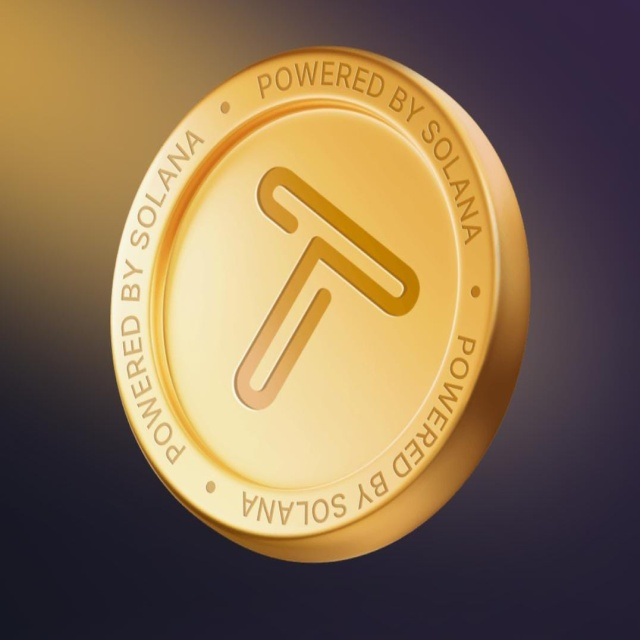

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


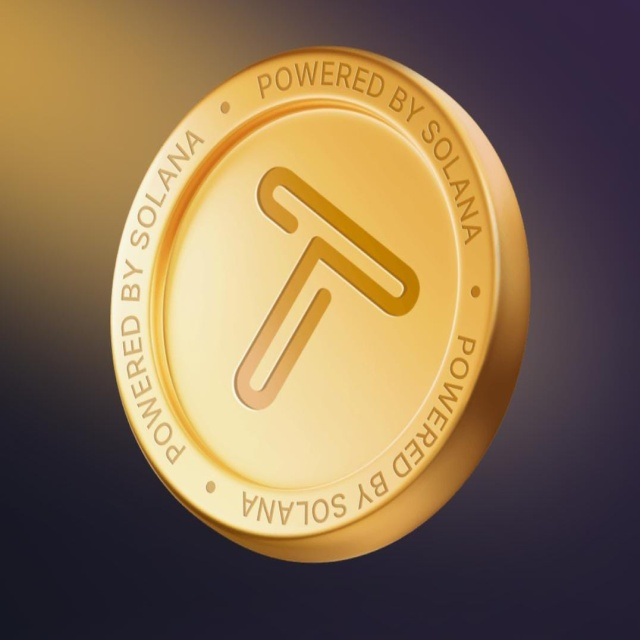

In [40]:
from google.colab import files
from IPython.display import display, Image, HTML
import ipywidgets as widgets
import io
import numpy as np
from PIL import Image as PILImage

def create_prediction_interface():
    model = tf.keras.models.load_model("/content/best_model.h5")

    style = """
    <style>
        .prediction-box {
            padding: 20px;
            margin: 10px 0;
            border-radius: 8px;
            font-family: Arial, sans-serif;
        }
        .prediction-yes {
            background-color: #d4edda;
            border: 1px solid #c3e6cb;
            color: #155724;
        }
        .prediction-no {
            background-color: #f8d7da;
            border: 1px solid #f5c6cb;
            color: #721c24;
        }
    </style>
    """

    display(HTML(style))

    def predict_image(file):
        img = PILImage.open(file).convert('RGB')
        img = img.resize((128, 128))
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        prediction = model.predict(img_array)[0][0]

        display(Image(data=file.getvalue(), width=300))

        prediction_class = "Yes" if prediction > 0.5 else "No"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        style_class = "prediction-yes" if prediction > 0.5 else "prediction-no"

        prediction_html = f"""
        <div class="prediction-box {style_class}">
            <h3>Prediction Results:</h3>
            <p>This image {prediction_class.lower()} contains a transaction.</p>
            <p>Confidence: {confidence * 100:.2f}%</p>
        </div>
        """
        display(HTML(prediction_html))

    upload_button = widgets.FileUpload(
        accept='image/*',
        description='Upload Image',
        layout=widgets.Layout(width='300px')
    )

    def on_upload_change(change):
        if change['type'] == 'change' and change['new']:

            file = io.BytesIO(list(change['new'].values())[0]['content'])
            predict_image(file)
            upload_button.value.clear()
            upload_button._counter = 0

    upload_button.observe(on_upload_change, names='value')

    print("Upload an image to check if it contains a transaction")
    display(upload_button)


create_prediction_interface()